In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
data = []
with open("multinli_1.0_train.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))

In [15]:
len(data)

392702

In [16]:

for i  in range (10):
    print('data'+str(i))
    print('annotation:',data[i]['annotator_labels'])
    print('sentence1:',data[i]['sentence1'])
    print('sentence2:',data[i]['sentence2'])
    print('\n')

data0
annotation: ['neutral']
sentence1: Conceptually cream skimming has two basic dimensions - product and geography.
sentence2: Product and geography are what make cream skimming work. 


data1
annotation: ['entailment']
sentence1: you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him
sentence2: You lose the things to the following level if the people recall.


data2
annotation: ['entailment']
sentence1: One of our number will carry out your instructions minutely.
sentence2: A member of my team will execute your orders with immense precision.


data3
annotation: ['entailment']
sentence1: How do you know? All this is their information again.
sentence2: This information belongs to them.


data4
annotation: ['neutral']
sentence1: yeah i tell you what though if you 

In [17]:
extracted_data = [{'sentence1': item['sentence1'], 

                   'sentence2': item['sentence2'], 

                   'gold_label': item['gold_label']} 

                  for item in data if item['gold_label'] in ['neutral', 'entailment', 'contradiction']]

# Convertir en DataFrame pour simplifier le traitement

df = pd.DataFrame(extracted_data)

# Aperçu des données extraites

df.head()

,sentence1,sentence2,gold_label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,neutral
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,entailment
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,entailment
3,How do you know? All this is their information...,This information belongs to them.,entailment
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,neutral


In [18]:
df_subset = df.sample(n=5000, random_state=42)

In [19]:
X_subset = df_subset[['sentence1', 'sentence2']]

In [20]:
len(X_subset)

5000

In [21]:
y_subset = df_subset['gold_label']

In [22]:
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset
)

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

In [32]:
# Définir un transformateur personnalisé pour extraire une colonne spécifique
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.column]

In [34]:
vectorizer1 = Pipeline([
    ('selector', ColumnSelector('sentence1')),
    ('tfidf', TfidfVectorizer())
])

vectorizer2 = Pipeline([
    ('selector', ColumnSelector('sentence2')),
    ('tfidf', TfidfVectorizer())
])

In [35]:
# Fusionner les représentations vectorielles des deux colonnes
vectorizer = FeatureUnion([("vec1", vectorizer1), ("vec2", vectorizer2)])

# Pipeline avec FeatureUnion et SVM
model = Pipeline([
    ('features', vectorizer),
    ('svm', SVC(kernel='linear'))
])

In [36]:
model.fit(X_train_subset, y_train_subset)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('vec1',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(column='sentence1')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('vec2',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(column='sentence2')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('svm', SVC(kernel='linear'))])

In [38]:
y_pred = model.predict(X_test_subset)

In [42]:
accuracy = accuracy_score(y_test_subset, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.4030


               precision    recall  f1-score   support

contradiction       0.46      0.48      0.47       340
   entailment       0.35      0.29      0.32       324
      neutral       0.39      0.43      0.41       336

     accuracy                           0.40      1000
    macro avg       0.40      0.40      0.40      1000
 weighted avg       0.40      0.40      0.40      1000



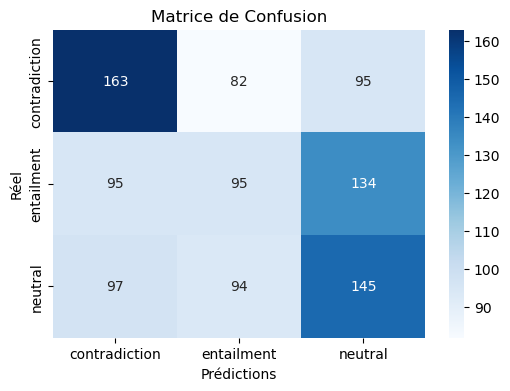

In [40]:
print(classification_report(y_test_subset, y_pred))

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test_subset, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion")
plt.show()